<a href="https://colab.research.google.com/github/sushant1212/CS-F425-Project-CIMON/blob/main/CIMON_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
# regular imports for pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# mounting drive, so that the dataset will be downloaded there directly. 
# this is done since the dataset takes time to download and hence it is better to download it once and use it later directly once the session times out
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# changing directory
%cd /content/drive/MyDrive
PATH  = "/content/drive/MyDrive/DL_CIMON/"

/content/drive/MyDrive


In [4]:
# importing torchvison datasets, and other torchvision tools for image processing
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.optim as optim

In [5]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from tqdm import tqdm

In [6]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [7]:
# Seeding for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [8]:
# Converting the images to tensors and normalizing them.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# The lines below are for downloading the dataset. If the dataset is downloaded already, then set the download=False

training_data = datasets.STL10(
    root="DL_CIMON",
    split="train",
    transform=transform,
    download=False
)


In [9]:
# HYPERPARAMS:
BATCH_SIZE = 256 # number of images used for pseudo graph construction
NO_OF_SAMPLES = 20000 
N_CLUSTERS = 5 # used in spectral clustering. Paper used a value of 70 for 5000 samples
THRESHOLD = 0.3 # used in pseudo graph, paper has used a value of 0.1
L = 128 # Length of the hash code
TAU = 0.5 
NETA = 0.3 # used in the loss function

### F( ) model code

In [12]:
class modelF(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = models.vgg11_bn(pretrained=True)
        self.model.classifier = nn.Sequential(*[self.model.classifier[i] for i in range(4)]) # removing the last layers of the pretrained model
    def forward(self, x):
        return self.model(x)

## Defining the Network

In [13]:
class HashingNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.G = modelF()
        self.hashing_net = nn.Sequential(
            nn.ReLU(inplace=True), 
            nn.Dropout(p=0.5, inplace=False), 
            nn.Linear(4096, L, bias=True), 
            nn.Tanh())
    
    def forward(self, x):
        x = self.G(x)
        x = self.hashing_net(x)
        return x

In [32]:
# Loading the model:
model = HashingNet()

model.load_state_dict(torch.load("/content/drive/MyDrive/DL_CIMON/run3.pth"))
model.eval()
for param in model.parameters():
    param.requires_grad = False

In [33]:
class0 = []
class1 = []
class2 = []

count0 = 0
count1 = 0
count2 = 0

In [34]:
i = 0
while count0!=20 or count1!=20 or count2!=20 or count2!=20:
    X, y = training_data[i]
    if(y==0 and count0!=20):
        class0.append(X)
        count0+=1
    elif(y==1 and count1!=20):
        class1.append(X)
        count1+=1
    elif(y==2 and count2!=20):
        class2.append(X)
        count2+=1
    i+=1

In [35]:
X = torch.cat([class0[i].unsqueeze(0) for i in range(20)], dim = 0)
Y = torch.cat([class1[i].unsqueeze(0) for i in range(20)], dim = 0)
Z = torch.cat([class2[i].unsqueeze(0) for i in range(20)], dim = 0)

In [36]:
M = torch.cat([X, Y, Z], dim = 0)

In [37]:
l = [0 for i in range(20)]
m = [1 for i in range(20)]
n = [2 for i in range(20)]
labels = l+m+n

In [38]:
hashes = model(M.float())

In [39]:
hashes.shape

torch.Size([60, 128])

In [40]:
from sklearn.decomposition import PCA


In [41]:
pca = PCA(n_components=2)
m = hashes.cpu().detach().numpy()
pca_result = pca.fit_transform(m)

In [42]:
colors = {}
colors[0] = 'g'
colors[1] = 'r'
colors[2] = 'b'


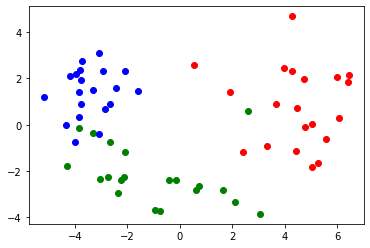

In [43]:
for i in range(len(pca_result)):
    plt.scatter(pca_result[i][0], pca_result[i][1], label=str(labels[i]), color=colors[labels[i]])
plt.show()